#### Importando bibliotecas

In [3]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import copy
import itertools
import os
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

#### Funções necessárias para armazenar os dados e rodar o modelo

In [5]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.
    Reorganiza os dados para que o lado com lesão sempre fique no vetor esquerdo
    e o lado contralateral saudável no vetor direito.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Listas temporárias para armazenar os dados originais
    original_images_left = []
    original_images_right = []
    original_mask_left = []
    original_mask_right = []
    original_labels_left = []
    original_labels_right = []

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        sorted(os.listdir(path_left)), sorted(os.listdir(lesion_path_left)),
        sorted(os.listdir(path_right)), sorted(os.listdir(lesion_path_right))
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            sorted(os.listdir(img_path_left)), sorted(os.listdir(mask_path_left)),
            sorted(os.listdir(img_path_right)), sorted(os.listdir(mask_path_right))
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                original_images_left.append(data_left)
                original_mask_left.append(data_msk_left)
                original_labels_left.append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                original_images_right.append(data_right)
                original_mask_right.append(data_msk_right)
                original_labels_right.append(calculate_label(data_msk_right))

    # Determina qual lado tem lesão
    has_lesion_left = any(label == 1 for label in original_labels_left)
    has_lesion_right = any(label == 1 for label in original_labels_right)

    # Reorganiza os dados para que o lado com lesão fique sempre no vetor esquerdo
    if has_lesion_right and not has_lesion_left:
        # Lesão está no lado direito -> troca os lados
        patient_data["images_left"] = [np.fliplr(img) for img in original_images_right]
        patient_data["mask_left"] = [np.fliplr(mask) for mask in original_mask_right]
        patient_data["labels_left"] = original_labels_right
        
        patient_data["images_right"] = original_images_left
        patient_data["mask_right"] = original_mask_left
        patient_data["labels_right"] = original_labels_left
        
        print(f"Paciente {patient_id}: Lesão no lado direito -> trocando lados")
    else:
        # Lesão está no lado esquerdo ou não há lesão -> mantém a organização original
        patient_data["images_left"] = original_images_left
        patient_data["mask_left"] = original_mask_left
        patient_data["labels_left"] = original_labels_left
        
        patient_data["images_right"] = [np.fliplr(img) for img in original_images_right]
        patient_data["mask_right"] = [np.fliplr(mask) for mask in original_mask_right]
        patient_data["labels_right"] = original_labels_right
        
        if has_lesion_left:
            print(f"Paciente {patient_id}: Lesão no lado esquerdo -> mantendo organização")
        else:
            print(f"Paciente {patient_id}: Sem lesão -> mantendo organização")

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    
    return patient_data, labels_pair

In [6]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre:
    - rotação 180°
    - flip vertical
    - troca de lado
    - combinações entre elas
    (7 variações possíveis)
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    # Lista de todas combinações possíveis (sem a identidade)
    transformations = [
        (True, False, False),   # só rotate
        (False, True, False),   # só flip
        (False, False, True),   # só swap
        (True, True, False),    # rotate + flip
        (True, False, True),    # rotate + swap
        (False, True, True),    # flip + swap
        (True, True, True)      # rotate + flip + swap
    ]

    # Escolhe aleatoriamente uma transformação
    rotate, flip, swap = rng.choice(transformations)

    l_img = img_left.copy()
    r_img = img_right.copy()
    l_mask = mask_left.copy()
    r_mask = mask_right.copy()

    if rotate:
        l_img = rotate_180(l_img)
        r_img = rotate_180(r_img)
        l_mask = rotate_180(l_mask)
        r_mask = rotate_180(r_mask)

    if flip:
        l_img = flip_vertical(l_img)
        r_img = flip_vertical(r_img)
        l_mask = flip_vertical(l_mask)
        r_mask = flip_vertical(r_mask)

    if swap:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask

    return l_img, r_img, l_mask, r_mask

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [7]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    class_1_left = {}
    class_0_left = {}
    class_1_right = {}
    class_0_right = {}
    class_1_mask_left = {}
    class_0_mask_left = {}
    class_1_mask_right = {}
    class_0_mask_right = {}
    class_1_coordinates = {}
    class_0_coordinates = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        seed = hash(patient_id) % (2**32)  # Gera uma seed única por paciente
        rng = np.random.default_rng(seed)
        
        if len(labels_pair[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels[patient_id] = labels_pair[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 1: {class_1_count}")
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 0: {class_0_count}")
        
        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        sampled_indices = rng.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
        sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
        sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
        class_0_original_modified = {}
        class_0_original_modified[patient_id] = []
        class_0_opposite_modified = {}
        class_0_opposite_modified[patient_id] = []
        sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
        sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
        class_0_mask_original_modified = {}
        class_0_mask_original_modified[patient_id] = []
        class_0_mask_opposite_modified = {}
        class_0_mask_opposite_modified[patient_id] = []
        
        for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
            class_0_original_modified[patient_id].append(left_image)
            class_0_mask_original_modified[patient_id].append(left_mask)
        for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
            class_0_opposite_modified[patient_id].append(right_image)
            class_0_mask_opposite_modified[patient_id].append(right_mask)
        class_0_left = class_0_original_modified
        class_0_right = class_0_opposite_modified
        class_0_mask_left = class_0_mask_original_modified
        class_0_mask_right = class_0_mask_opposite_modified
        class_0_labels = [0] * (class_1_count)
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = rng.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
        
        class_1_count = len(class_1_labels)
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients


In [ ]:
def get_augmenter(input_shape, seed=42):
    """Cria uma camada de aumento de dados que aplica transformações aleatórias."""
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.RandomFlip("horizontal_and_vertical", seed=seed),
        layers.RandomRotation(0.25, seed=seed),
    ], name="augmenter")

def supervised_nt_xent_loss(projections, labels, temperature=0.1):
    """
    Calcula a perda NT-Xent supervisionada, onde 'labels' define os pares positivos.
    labels[i] = 1 indica que o par (left_i, right_i) é positivo (com lesão).
    """
    batch_size = tf.shape(projections)[0] // 2
    
    projections = tf.math.l2_normalize(projections, axis=1)
    similarity_matrix = tf.matmul(projections, projections, transpose_b=True)
    
    # Garantir que os labels tenham o formato correto
    labels = tf.reshape(labels, [-1])
    
    # Criar máscara para pares positivos (apenas onde label == 1 - COM lesão)
    positive_mask = tf.cast(tf.equal(labels, 1), tf.float32)
    
    # Construir a matriz de labels correta
    # Para cada par positivo (i), queremos que as posições (i, i+batch_size) e (i+batch_size, i) sejam 1
    labels_matrix = tf.zeros((2 * batch_size, 2 * batch_size), dtype=tf.float32)
    
    # Preencher os quadrantes off-diagonal com a máscara positiva
    indices_i = tf.range(batch_size)
    indices_j = indices_i + batch_size
    updates = positive_mask
    
    # Atualizar quadrante superior direito
    indices = tf.stack([indices_i, indices_j], axis=1)
    labels_matrix = tf.tensor_scatter_nd_update(labels_matrix, indices, updates)
    
    # Atualizar quadrante inferior esquerdo
    indices = tf.stack([indices_j, indices_i], axis=1)
    labels_matrix = tf.tensor_scatter_nd_update(labels_matrix, indices, updates)
    
    # A diagonal principal deve ser zero (não comparamos uma imagem com ela mesma)
    labels_matrix = tf.linalg.set_diag(labels_matrix, tf.zeros(2 * batch_size))
    
    # Calcula a perda
    logits = similarity_matrix / temperature
    
    # Para evitar log(0), adicionamos um pequeno epsilon
    probs = tf.nn.softmax(logits, axis=1) + 1e-8
    loss = tf.keras.losses.categorical_crossentropy(
        y_true=labels_matrix,
        y_pred=probs,
        from_logits=False,
    )
    
    return tf.reduce_mean(loss)

class SSCLModel(Model):
    def __init__(self, encoder, projection_head, augmenter):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.augmenter = augmenter
    
    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    def train_step(self, data):
        # Desempacota os dados
        left_hemispheres, right_hemispheres, labels = data

        # Aplica aumento apenas no hemisfério direito (mantém o esquerdo como âncora)
        augmented_right = self.augmenter(right_hemispheres)

        # Concatena os lotes: âncoras (left originais) + right aumentados
        all_views = tf.concat([left_hemispheres, augmented_right], axis=0)
        
        with tf.GradientTape() as tape:
            embeddings = self.encoder(all_views)
            projections = self.projection_head(embeddings)
            
            # Inverte a lógica dos labels: agora queremos que pares com lesão (label=1)
            # sejam tratados como positivos no aprendizado contrastivo
            loss = supervised_nt_xent_loss(projections, labels)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {"loss": loss}

    def test_step(self, data):
        # Lógica similar para o passo de teste
        left_hemispheres, right_hemispheres, labels = data
        
        # Aplica aumento apenas no hemisfério direito
        augmented_right = self.augmenter(right_hemispheres)
        
        # Concatena os lotes: âncoras (left originais) + right aumentados
        all_views = tf.concat([left_hemispheres, augmented_right], axis=0)
        
        embeddings = self.encoder(all_views)
        projections = self.projection_head(embeddings)
        
        loss = supervised_nt_xent_loss(projections, labels)
        
        return {"loss": loss}

def build_encoder(input_shape):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3)
    ], name="encoder")

def build_projection_head(embedding_dim=64, projection_dim=32):
    return models.Sequential([
        layers.InputLayer(input_shape=(embedding_dim,)),
        layers.Dense(projection_dim, activation='relu'),
        layers.BatchNormalization(),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="projection_head")

def build_siamese_classifier(encoder, input_shape, num_classes):
    """
    Constrói um classificador tradicional usando o encoder pré-treinado.
    """
    # Congelar o encoder inicialmente para fine-tuning gradual
    encoder.trainable = False
        
    # Adicionar camadas de classificação
    model = models.Sequential([
        layers.Input(shape=input_shape),
        encoder,
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [20]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


#### Rodando funções de Pré-Processamento

In [ ]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10: Lesão no lado direito -> trocando lados
Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1131
Paciente sub-02A13: Lesão no lado direito -> trocando lados
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1145
Paciente sub-03C08: Lesão no lado direito -> trocando lados
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1006
Paciente sub-06C09: Lesão no lado direito -> trocando lados
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1113
Paciente sub-14F04: Lesão no lado direito -> trocando lados
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1180
Paciente sub-16E03: Lesão no lado direito -> trocando lados
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1256
Paciente sub-16G09: Lesão no lado direito -> trocando lados
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1128
Paciente sub-16I12: Lesão no lado direito -> trocando lados
Paciente sub-16I12 carregado com sucesso.
Total de recorte

In [10]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
test_left = normalize_minmax(np.array([elemento for lista in test_left.values() for elemento in lista]))
test_right = normalize_minmax(np.array([elemento for lista in test_right.values() for elemento in lista]))

41
Paciente sub-00H10: Total de pares de recortes com label 1: 11
Paciente sub-00H10: Total de pares de recortes com label 0: 1120
Paciente sub-00H10: Total de patches no final: 22
Paciente sub-02A13: Total de pares de recortes com label 1: 93
Paciente sub-02A13: Total de pares de recortes com label 0: 1052
Paciente sub-02A13: Total de patches no final: 186
Paciente sub-03C08: Total de pares de recortes com label 1: 41
Paciente sub-03C08: Total de pares de recortes com label 0: 965
Paciente sub-03C08: Total de patches no final: 82
Paciente sub-06C09: Total de pares de recortes com label 1: 8
Paciente sub-06C09: Total de pares de recortes com label 0: 1105
Paciente sub-06C09: Total de patches no final: 16
Paciente sub-14F04: Total de pares de recortes com label 1: 8
Paciente sub-14F04: Total de pares de recortes com label 0: 1172
Paciente sub-14F04: Total de patches no final: 16
Paciente sub-16E03: Total de pares de recortes com label 1: 73
Paciente sub-16E03: Total de pares de recortes

In [11]:
# Adiciono camada de cor
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
test_left = np.expand_dims(test_left, axis=-1)
test_right = np.expand_dims(test_right, axis=-1)

In [12]:
wandb.init(project="gabrieljpanza-universidade-federal-fluminense")
wandb.run.name = "SiameseModel-Axial-Contrastive"

wandb: Currently logged in as: gabrieljpanza (gabrieljpanza-universidade-federal-fluminense) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
wandb.config.epochs = 75
wandb.config.batch_size = 128
wandb.config.learning_rate = 0.001

#### Começando o Treinamento

In [14]:
print("\n--- Iniciando Etapa 1: Pré-treinamento Auto-Supervisionado com Labels ---")

# Preparar os dados de pré-treinamento (incluindo labels)
pretrain_data_left = np.concatenate([train_left_balanced, valid_left_balanced], axis=0).astype(np.float32)
pretrain_data_right = np.concatenate([train_right_balanced, valid_right_balanced], axis=0).astype(np.float32)
pretrain_labels = np.concatenate([y_train_balanced, y_valid_balanced], axis=0).astype(np.float32)

print(f"Total de imagens esquerdas para treinamento: {len(pretrain_data_left)}")
print(f"Total de imagens direitas para treinamento: {len(pretrain_data_right)}")
input_shape = pretrain_data_left[0].shape
print(f"Shape das imagens para treinamento: {input_shape}")

encoder = build_encoder(input_shape)
projection_head = build_projection_head()
augmenter = get_augmenter(input_shape)


--- Iniciando Etapa 1: Pré-treinamento Auto-Supervisionado com Labels ---
Total de imagens esquerdas para treinamento: 5634
Total de imagens direitas para treinamento: 5634
Shape das imagens para treinamento: (40, 40, 1)


c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
# Criar e compilar o modelo de pré-treinamento
sscl_model = SSCLModel(encoder, projection_head, augmenter)
sscl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Criar dataset para pré-treinamento empacotando os dados para manter a correspondência
paired_data = tf.data.Dataset.from_tensor_slices({
    'left': pretrain_data_left,
    'right': pretrain_data_right,
    'label': pretrain_labels
})
# Aplica shuffle aos pares completos (mantendo a correspondência)
paired_data = paired_data.shuffle(len(pretrain_data_left))

# Desempacota para o formato esperado pelo modelo
pretrain_dataset = paired_data.map(lambda x: (x['left'], x['right'], x['label']))
pretrain_dataset = pretrain_dataset.batch(wandb.config.batch_size)

# Treinar o modelo contrastivo
history_sscl = sscl_model.fit(
    pretrain_dataset, 
    epochs=100,
)

# Salvar os pesos do encoder pré-treinado
encoder.save_weights('siamese_encoder_pretrained.weights.h5')
print("Pesos do encoder pré-treinado salvos com sucesso!")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 2.3643
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.2133
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 2.1081
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 2.1361
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 2.0792
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.0672
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 2.0627
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.0441
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.0547
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 2.0300
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 2.0356
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 2.0347
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 2.0262
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 2.0542
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - lo

In [ ]:
print("\n--- Iniciando Etapa 2: Fine-tuning Supervisionado ---")

# Construir o classificador siamês usando o encoder pré-treinado
siamese_classifier = build_siamese_classifier(encoder, input_shape, len(set(labels_pair)))

# Compilar o modelo para classificação
siamese_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)

siamese_classifier.summary()


--- Iniciando Etapa 2: Fine-tuning Supervisionado ---


Model: "siamese_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 40, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 40, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 64)        │    328,928 │ left_input[0][0], │
│ (Sequential)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 64)        │          0 │ encoder[0][0],    │
│                     │                   │            │ encoder[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ subtract[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 335,457 (1.28 MB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 329,056 (1.26 MB)

In [ ]:
# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    'best_SNN_model.weights.h5', 
    monitor='val_loss', 
    save_best_only=True,  
    save_weights_only=True, 
    mode='min'
)

# Treinamento do classificador siamês
history = siamese_classifier.fit(
    [train_left_balanced, train_right_balanced], 
    y_train_balanced, 
    validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), 
    batch_size=wandb.config.batch_size, 
    epochs=150, 
    callbacks=[checkpoint, WandbMetricsLogger()]
)

print("Treinamento concluído com sucesso!")

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5097 - loss: 0.7602 - precision: 0.5139 - recall: 0.5025 - val_accuracy: 0.5097 - val_loss: 0.6914 - val_precision: 0.5150 - val_recall: 0.3310
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4867 - loss: 0.7450 - precision: 0.4865 - recall: 0.4946 - val_accuracy: 0.5034 - val_loss: 0.6914 - val_precision: 0.5059 - val_recall: 0.2966
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4965 - loss: 0.7214 - precision: 0.4937 - recall: 0.4948 - val_accuracy: 0.4862 - val_loss: 0.6924 - val_precision: 0.4695 - val_recall: 0.2124
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5042 - loss: 0.7139 - precision: 0.4997 - recall: 0.5035 - val_accuracy: 0.4579 - val_loss: 0.6937 - val_precision: 0.3930 - val_recall: 0.1545
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5100 - loss: 0.7064 - precision: 0.5100 - recall: 0.5356 - val_accuracy: 0.4579 - val_loss: 0.

#### Resultados do Treinamento

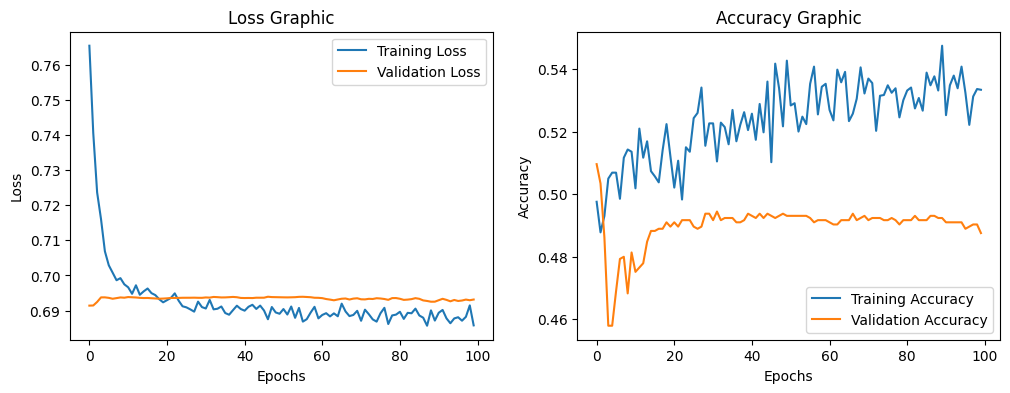

In [ ]:
# Plotar o histórico do treinamento
plot_training_history(history)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


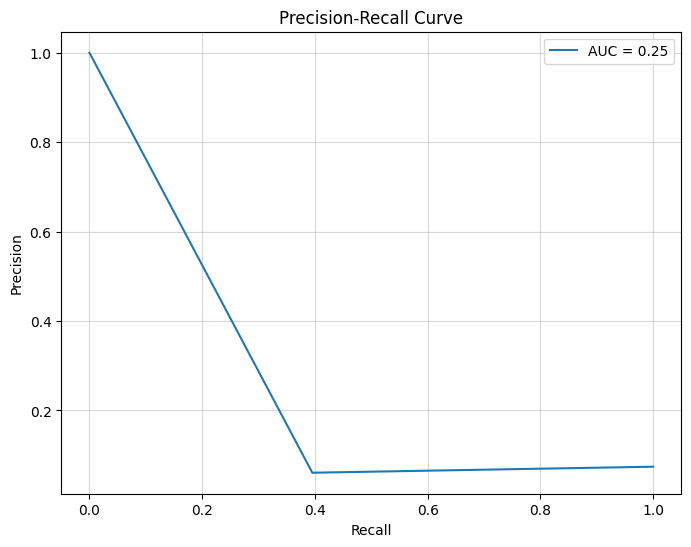

In [24]:
# Carregando pesos da melhor época
siamese_classifier.load_weights('siamese_trained_final.weights.h5')

# Avaliar o modelo na validação
y_pred_train = (siamese_classifier.predict([train_left_balanced, train_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo na validação
y_pred_valid = (siamese_classifier.predict([valid_left_balanced, valid_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo no teste
y_pred_test = (siamese_classifier.predict([test_left, test_right]) > 0.5).astype(int)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [25]:
# Gerar o relatório de classificação
print("Treino:")
print(classification_report(y_train_balanced, y_pred_train))
print("\n#########################################################\n")
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
#print(classification_report(y_test, y_pred_test)) 
print(classification_report(y_test, y_pred_test)) 

Treino:
              precision    recall  f1-score   support

           0       0.57      0.70      0.63      2092
           1       0.61      0.47      0.53      2092

    accuracy                           0.59      4184
   macro avg       0.59      0.59      0.58      4184
weighted avg       0.59      0.59      0.58      4184


#########################################################

Validação:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       725
           1       0.55      0.43      0.48       725

    accuracy                           0.54      1450
   macro avg       0.54      0.54      0.54      1450
weighted avg       0.54      0.54      0.54      1450


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.91      0.51      0.65      4354
           1       0.06      0.40      0.11       349

    accuracy                        

Validação:


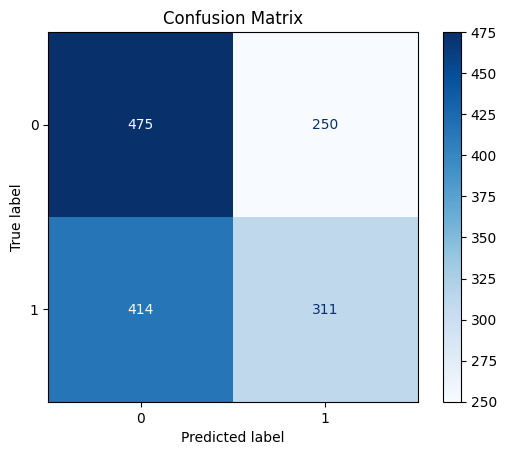

Teste:


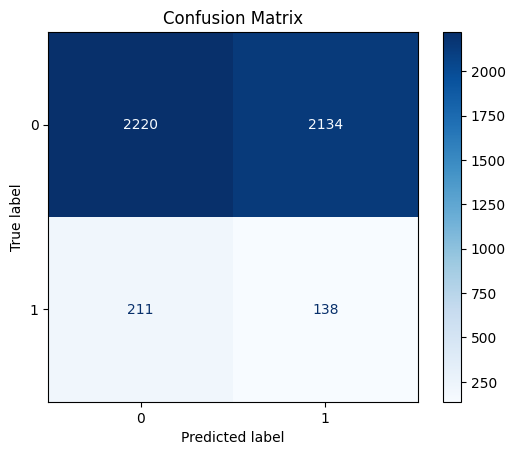

In [26]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid)
print("Teste:")
plot_confusion_matrix(y_test, y_pred_test)

In [23]:
# Finaliza o wandb
wandb.finish()

epoch/accuracy,▂▁▁▂▂▂▂▃▂▃▂▂▂▄▃▅▄▄▄▄▃▂▅▃▃▄▅▅▄▅▅▅▅▆▆▆▇▇▇█
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▅▄▃▃▂▂▂▁
epoch/precision,▁▂▂▁▂▃▁▃▃▂▃▃▄▂▂▃▂▄▃▄▄▄▄▅▄▄▄▄▅▅▅▅▆▅▄▆▆▆▇█
epoch/recall,▆▄▄▃▁▁▁▁▂▁▂▃▂▂▃▃▄▄▄▄▄▄▄▄▅▆▅▅▆▅▇▆▇▇▇▇████
epoch/val_accuracy,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▃▂▁▁▃▃▃▂▃▅▂▃▂▃▂▃▄▄▄▆▅▇▇█
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▅█▂▃
epoch/val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch/val_recall,▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▂▂▃▂▃▅▄▅▅▅▅▄▅▅▆▇▇██▇█████
epoch/accuracy,0.6054


#### Rodando processos de Pós-Processamento

In [ ]:
def load_patient_data_per_slice(folder, patient_id): # carregar dados de teste, mantendo os dados de cada fatia em um vetor
    patient_path = os.path.join(folder, patient_id)  # folder/patient/
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    labels_total = []
    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])  # folder/patient/left
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)  # folder/patient/left/slice_
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)
        
        slice_left_img = []
        slice_right_img = []
        slice_left_mask = []
        slice_right_mask = []
        slice_left_labels = []
        slice_right_labels = []

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()

            if len(data_left) > 0 or len(data_msk_left) > 0:
                slice_left_img.append(data_left)
                slice_left_mask.append(data_msk_left)
                slice_left_labels.append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()

            if len(data_right) > 0 or len(data_msk_right) > 0:
                slice_right_img.append(data_right)
                slice_right_mask.append(data_msk_right)
                slice_right_labels.append(calculate_label(data_msk_right))

        patient_data["images_left"].append(slice_left_img)
        patient_data["mask_left"].append(slice_left_mask)
        patient_data["labels_left"].append(slice_left_labels)

        patient_data["images_right"].append(slice_right_img)
        patient_data["mask_right"].append(slice_right_mask)
        patient_data["labels_right"].append(slice_right_labels)

        labels_pair = []
        for label_left, label_right in zip(slice_left_labels, slice_right_labels):
            if label_left == 0 and label_right == 0:
                labels_pair.append(0)
            else:
                labels_pair.append(1)
        labels_total.append(labels_pair)

    patient_data["labels_pair"] = labels_total

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_total)}")
    return patient_data, labels_total

def test_labels_near(predictions): # pós-processamento
    new_pred = copy.deepcopy(predictions)
    previous_pos = 0
    actual_pos = 0
    next_pos = 0

    for i in range(1, len(predictions) - 1):

        # testa posições "perto", mas tá errado pela ordem dos recortes dentro da fatia
        for j in range(1, len(predictions[i])-1):
            if predictions[i][j] == 0 and predictions[i][j-1] == 1 and predictions[i][j+1] == 1:
                new_pred[i][j+1] = 0
                new_pred[i][j-1] = 0
                print(f"ANTES unit: {predictions[i]}")
                print(f"DEPOIS: {new_pred[i]}\n")

        # testa 3 fatias sequenciais
        previous_pos = np.count_nonzero(predictions[i - 1])
        actual_pos = np.count_nonzero(predictions[i])
        next_pos = np.count_nonzero(predictions[i + 1])

        if (previous_pos == 0 and actual_pos >= 1 and next_pos == 0):
            new_pred[i] = np.array([0 for j in range(len(predictions[i]))])
            print(f"ANTES whole: {predictions[i]}")
            print(f"DEPOIS: {new_pred[i]}\n")

    return new_pred

In [ ]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
test_patient_ids = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

X_slices_left, X_slices_right, y_slices, mask_slices_left, mask_slices_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in test_patient_ids:
    # Carrega os dados do paciente
    patient_data_test, labels_pair_test = load_patient_data_per_slice(folder, patient_id)
    
    if patient_data_test is not None:
        X_slices_left[patient_id] = patient_data_test["images_left"]
        X_slices_right[patient_id] = patient_data_test["images_right"]
        mask_slices_left[patient_id] = patient_data_test["mask_left"]
        mask_slices_right[patient_id] = patient_data_test["mask_right"]
        y_slices[patient_id] = labels_pair_test

In [ ]:
# Normalização e tratamento de dimensões do dado de teste
test_single_left = {}
test_single_right = {}

for id in test_patient_ids:
    test_single_left[id] = []
    test_single_right[id] = []

    for i in range(0, len(X_slices_left[id])):
        test_single_left[id].append([])
        test_single_right[id].append([])

        for j in range(0, len(X_slices_left[id][i])):
            # print(f"Dados do paciente {id} da fatia {i} do dado {j} esquerdo")
            test_single_left[id][i].append(normalize_minmax(np.array(X_slices_left[id][i][j]))) # normaliza as imagens
            test_single_right[id][i].append(normalize_minmax(np.array(X_slices_right[id][i][j])))

        test_single_left[id][i] = np.expand_dims(test_single_left[id][i], axis=-1) # expande eixo pra passar rede pra predict
        test_single_right[id][i] = np.expand_dims(test_single_right[id][i], axis=-1)

In [ ]:
# Construir e compilar o modelo CNN
input_shape = (test_single_left[test_patient_ids[0]][0][0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

y_test_slices_pred = {}

for patient in test_patient_ids:
    print(f"paciente {patient}")
    y_test_slices_pred[patient] = []

    for i in range(0, len(X_slices_left[patient])):
        print(f"fatia {i}")
        left = test_single_left[patient][i]
        right = test_single_right[patient][i]
        y_test_slices_pred[patient].append((siamese_model.predict([left, right]) > 0.5).astype(int).flatten())

#### Comparando resultados sem e com Pós-Processamento

In [ ]:
# labels certos -> y_slices
# predição não processada -> y_test_slices_pred
# predição processada -> processed labels

processed_labels = {}

# crio um novo vetor com os labels processados
for patient_name in test_patient_ids:
    processed_labels[patient_name] = test_labels_near(y_test_slices_pred[patient_name])


In [ ]:
labels_pred_processed = list(itertools.chain(*list(itertools.chain(*processed_labels.values()))))

# Gerar a matriz de confusão
print("RESULTADO ORIGINAL:")
plot_confusion_matrix(y_test, y_pred_test)
print("\n#########################################################\n")
print("PÓS PROCESSADO:")
plot_confusion_matrix(y_test, labels_pred_processed)

# print(labels_true)
# print(labels_pred_raw)
# print(labels_pred_processed)

# print(np.count_nonzero(labels_true))
# print(np.count_nonzero(labels_pred_raw))
# print(np.count_nonzero(labels_pred_processed))

In [ ]:
print("Teste") 
print(classification_report(y_test, labels_pred_processed)) 

#### Plotando PDFs para comparação dos resultados e análise das classificações

In [ ]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

def enhance_contrast(img, factor=1.1):
    img = img.astype(np.float32)
    img = img * factor
    return np.clip(img, 0, 255).astype(np.uint8)

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)

    reconstructed_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    
    half = len(coordinates) // 2
    classifications = []

    for i in range(half):
        true = labels_true[i + index]
        pred = labels_pred[i + index]
        if pred == true:
            classif = "TP" if pred == 1 else "TN"
        else:
            classif = "FP" if pred == 1 else "FN"
        classifications.append(classif)
    
    # Repetir a classificação para o lado direito
    classifications.extend(classifications)

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classif = classifications[i]

        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask, (index + half)

# Reconstrói uma fatia do paciente usando coordenadas + indexes mapeados
def build_image_with_grid_indexed(patient_id, slice_index, balanced_index_patients,
                                  labels_pred, labels_true, image_path, mask_path,
                                  coordinates_path, patch_metadata):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)

    if img is None or mask is None or not coordinates:
        return None, None

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)
    
    height, width = img.shape[:2]
    reconstructed_img = np.zeros((height, width, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((height, width, 3), dtype=np.uint8)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        # Identifica o global_index da coordenada
        global_index = None
        for idx, meta in patch_metadata.items():
            if meta[0] == patient_id and meta[1] == slice_index and meta[3:] == (y1, y2, x1, x2):
                global_index = idx
                break

        if global_index in balanced_index_patients:
            label_pos = balanced_index_patients.index(global_index)
            true_label = labels_true[label_pos]
            pred_label = labels_pred[label_pos]

            if pred_label == true_label:
                classif = "TP" if pred_label == 1 else "TN"
            else:
                classif = "FP" if pred_label == 1 else "FN"

            patch_img = img[y1+3:y2-3, x1+3:x2-3]
            patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        else:
            classif = "TN"
            patch_img = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)
            patch_mask = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask

# Gera metadados global_index → (patient, slice, side, y1, y2, x1, x2)
def generate_patch_metadata(patients, coordinates_path):
    patch_metadata = {}
    global_index = 0
    for patient in patients:
        patient_dir = os.path.join(coordinates_path, patient)
        if not os.path.isdir(patient_dir):
            continue
        for filename in sorted(os.listdir(patient_dir)):
            if filename.endswith(".txt"):
                slice_index = int(filename.split("_")[1].split(".")[0])
                coord_file = os.path.join(patient_dir, filename)
                with open(coord_file, "r") as f:
                    coords = [tuple(map(int, line.strip().split(","))) for line in f if line.strip()]
                half = len(coords) // 2
                for i, (y1, y2, x1, x2) in enumerate(coords):
                    side = 'left' if i < half else 'right'
                    patch_metadata[global_index] = (patient, slice_index, side, y1, y2, x1, x2)
                    global_index += 1
    print(f"✅ Mapeamento gerado com {len(patch_metadata)} patches.")
    return patch_metadata


In [ ]:
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling+Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder, patients, image_left, image_right,
    mask_left, mask_right, labels_true, labels_pred
):
    os.makedirs(pdf_folder, exist_ok=True)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    index = 0

    for patient in patients:
        if patient not in image_left or patient not in image_right:
            print(f"❌ Paciente {patient} não encontrado nos dados.")
            continue

        num_patches = len(image_left[patient])
        patient_folder = os.path.join(pdf_folder, patient)
        os.makedirs(patient_folder, exist_ok=True)
        pdf_filename = os.path.join(patient_folder, f"Paciente_{patient}.pdf")

        with PdfPages(pdf_filename) as pdf:
            for i in range(num_patches):
                if index >= len(labels_true) or index >= len(labels_pred):
                    break

                true_label = labels_true[index]
                pred_label = labels_pred[index]
                if pred_label == true_label:
                    classif = "TP" if pred_label == 1 else "TN"
                else:
                    classif = "FP" if pred_label == 1 else "FN"
                color = colors[classif]

                patch_l = image_left[patient][i]
                patch_r = image_right[patient][i]
                mask_l = mask_left[patient][i]
                mask_r = mask_right[patient][i]

                patch_l_border = add_border(patch_l, color)
                patch_r_border = add_border(patch_r, color)
                mask_l_border = add_border(mask_l, color)
                mask_r_border = add_border(mask_r, color)

                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(patch_l_border)
                axs[0, 0].set_title("Esquerda")
                axs[0, 1].imshow(patch_r_border)
                axs[0, 1].set_title("Direita")
                axs[1, 0].imshow(mask_l_border)
                axs[1, 0].set_title("Másc. Esq.")
                axs[1, 1].imshow(mask_r_border)
                axs[1, 1].set_title("Másc. Dir.")

                for ax in axs.flat:
                    ax.axis("off")

                fig.suptitle(f"{patient} | {classif} | idx {index}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)

                index += 1

        print(f"✅ PDF salvo: {pdf_filename}")

    print(f"\n📂 Todos os PDFs foram salvos em: {pdf_folder}")

plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_final_patches_treino",
    patients=train_patients,
    image_left=train_left_balanced,
    image_right=train_right_balanced,
    mask_left=balanced_mask_left,
    mask_right=balanced_mask_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train
)

plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_final_patches_validacao",
    patients=valid_patients,
    image_left=valid_left_balanced,
    image_right=valid_right_balanced,
    mask_left=balanced_mask_left,
    mask_right=balanced_mask_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid
)